## Libraries




In [10]:
import datetime
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import regularizers
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau, TensorBoard)
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.nn import softmax

## Dataset

In [11]:
train_dir = 'PATH'
test_dir = 'PATH'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


## Training and Test Sets

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   validation_split = 0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset = "training")

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = 0.2)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset = "validation")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


## Defining the model

In [13]:
def get_model(input_size, classes=7):
     #Initialising the CNN
     model = tf.keras.models.Sequential()

     # 1 - Convolution
     model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
     model.add(BatchNormalization())
     model.add(Activation('relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))

     # 2nd Convolution layer
     model.add(Conv2D(128,(5,5), padding='same'))
     model.add(BatchNormalization())
     model.add(Activation('relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))

     # 3rd Convolution layer
     model.add(Conv2D(512,(3,3), padding='same'))
     model.add(BatchNormalization())
     model.add(Activation('relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))

     # 4th Convolution layer
     model.add(Conv2D(512,(3,3), padding='same'))
     model.add(BatchNormalization())
     model.add(Activation('relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))

     # Flattening
     model.add(Flatten())

     # Fully connected layer 1st layer
     model.add(Dense(256))
     model.add(BatchNormalization())
     model.add(Activation('relu'))
     model.add(Dropout(0.25))

     # Fully connected layer 2nd layer
     model.add(Dense(512))
     model.add(BatchNormalization())
     model.add(Activation('relu'))
     model.add(Dropout(0.25))

     model.add(Dense(7, activation='softmax'))
     
     model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
     return model

In [14]:
fernet = get_model((row,col,1), classes)
fernet.summary()

c:\Users\flags\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [15]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, rankdir='LR', show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
checkpoint = ModelCheckpoint(filepath="Model_ckpt.weights.h5",
                             save_best_only=True,
                             save_weights_only=True,
                             verbose=1,
                             mode='max',
                             monitor='val_accuracy')

callbacks = [checkpoint]

## Training

In [17]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

c:\Users\flags\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.2150 - loss: 2.0819

c:\Users\flags\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.17188, saving model to Model_ckpt.weights.h5
358/358 ━━━━━━━━━━━━━━━━━━━━ 161s 442ms/step - accuracy: 0.2151 - loss: 2.0817 - val_accuracy: 0.1719 - val_loss: 1.9285
Epoch 2/60
  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:30 590ms/step - accuracy: 0.2812 - loss: 1.9537

c:\Users\flags\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.17188 to 0.17259, saving model to Model_ckpt.weights.h5
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2812 - loss: 1.9537 - val_accuracy: 0.1726 - val_loss: 1.9246
Epoch 3/60
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.2495 - loss: 1.9025
Epoch 3: val_accuracy improved from 0.17259 to 0.25568, saving model to Model_ckpt.weights.h5
358/358 ━━━━━━━━━━━━━━━━━━━━ 138s 386ms/step - accuracy: 0.2495 - loss: 1.9025 - val_accuracy: 0.2557 - val_loss: 1.8151
Epoch 4/60
  1/358 ━━━━━━━━━━━━━━━━━━━━ 2:24 404ms/step - accuracy: 0.2812 - loss: 1.9074
Epoch 4: val_accuracy improved from 0.25568 to 0.26420, saving model to Model_ckpt.weights.h5
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2812 - loss: 1.9074 - val_accuracy: 0.2642 - val_loss: 1.8060
Epoch 5/60
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.2820 - loss: 1.8455
Epoch 5: val_accuracy improved from 0.26420 to 0.33310, saving model to Model_ckpt.weights.h5
35

## Precision graph

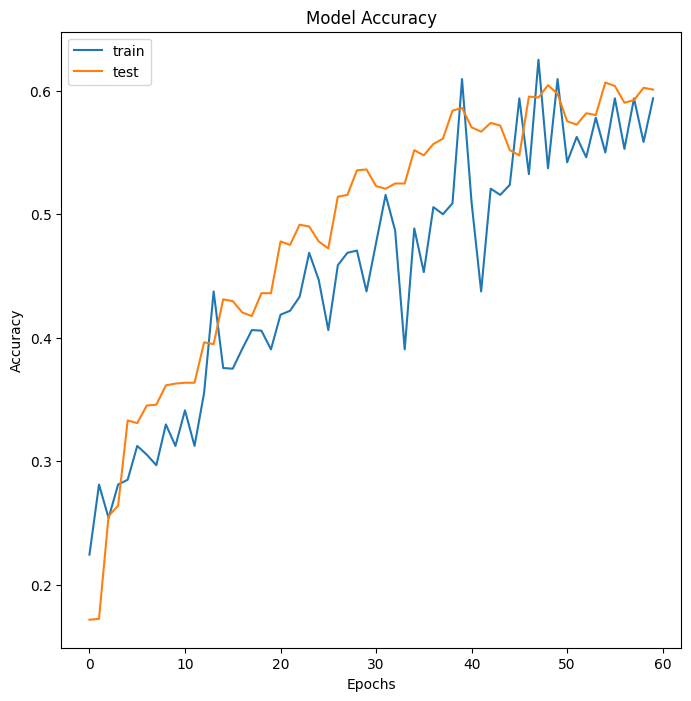

In [18]:
plt.figure(figsize=(8,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

## Model evaluation

In [19]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - accuracy: 0.6056 - loss: 1.0439
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5774 - loss: 1.0751
final train accuracy = 60.48 , validation accuracy = 60.06


## Confusion matrix and test suite classification

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step
Confusion Matrix
[[ 31   0  18  50  39  31  22]
 [  4   0   0   6   4   5   3]
 [ 32   0  15  55  50  32  20]
 [ 59   1  20 112  65  41  56]
 [ 39   3  13  59  58  40  34]
 [ 42   0  20  73  47  29  38]
 [ 22   0  14  48  40  21  21]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.16      0.15       191
     disgust       0.00      0.00      0.00        22
        fear       0.15      0.07      0.10       204
       happy       0.28      0.32      0.30       354
     neutral       0.19      0.24      0.21       246
         sad       0.15      0.12      0.13       249
    surprise       0.11      0.13      0.12       166

    accuracy                           0.19      1432
   macro avg       0.14      0.15      0.14      1432
weighted avg       0.18      0.19      0.18      1432



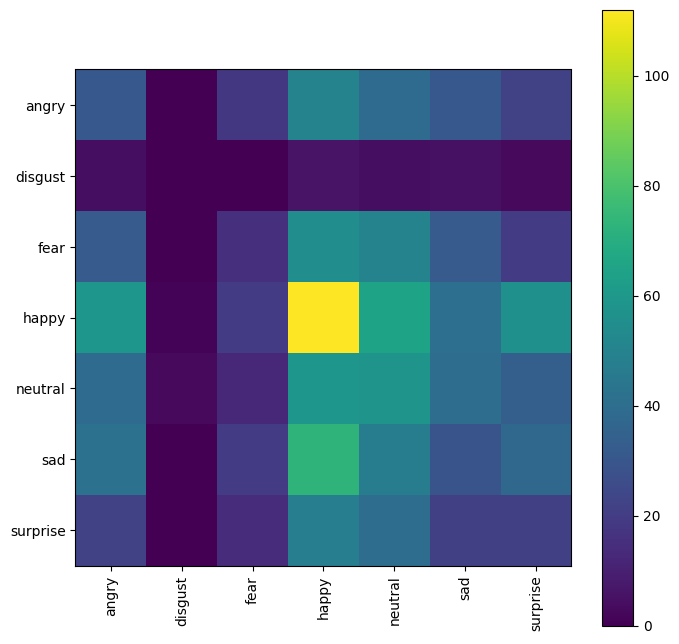

In [20]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Viewing results

In [21]:
classnames = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

(48, 48)


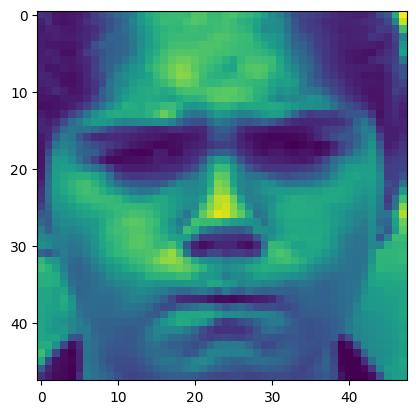

In [22]:
imagem2 = load_img("PATH",target_size = (48,48),color_mode = "grayscale")
imagem = np.array(imagem2)
plt.imshow(imagem)
print(imagem.shape)

In [23]:
imagem = np.expand_dims(imagem2,axis = 0) #makes image shape (1,48,48)
imagem = imagem.reshape(1,48,48,1)
prediction = fernet.predict(imagem)
result=np.argmax(prediction,axis=1)
result = list(prediction[0])
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
[np.float32(2.5224843e-36), np.float32(0.0), np.float32(1.0), np.float32(0.0), np.float32(0.0), np.float32(7.3943264e-31), np.float32(0.0)]


In [24]:
img_index = result.index(max(result))
print(classnames[img_index])

fearful


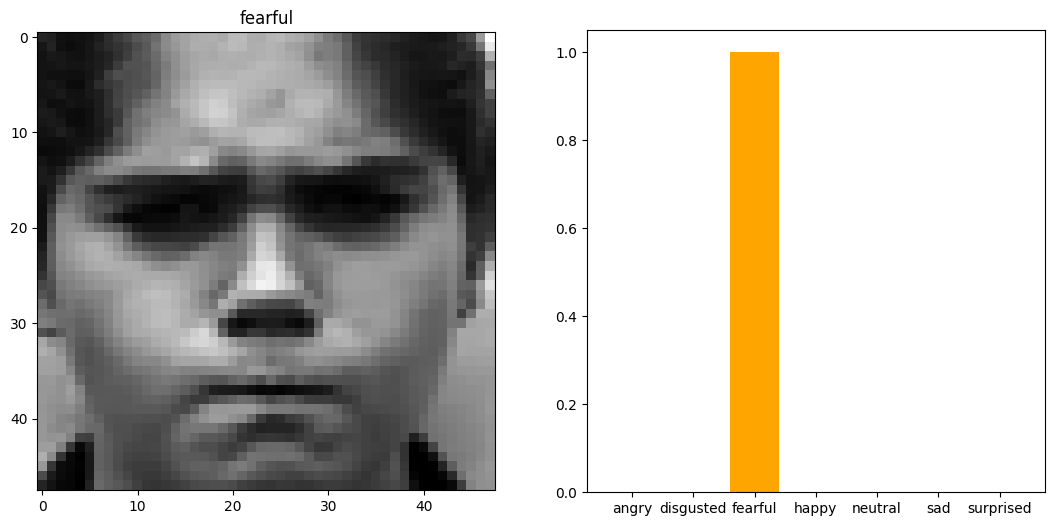

In [25]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
plt.imshow(imagem2, cmap='gray')
plt.title(classnames[img_index])

plt.subplot(1,2,2)
plt.bar(classnames, prediction[0], color = 'orange')
plt.show()